# Um modelo de clustering para identificação de grupos prioritários para a criação de cooperativas de produtos nativos na Amazônia Legal

## 1) Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

warnings.simplefilter('ignore')

## 2) Compreensão dos dados

### 2.1) Coleta dos dados

Os dados abaixo foram coletados do portal Comex Stat (http://comexstat.mdic.gov.br/pt/municipio) que oferece acesso gratuito a dados e estatísticas de comércio exterior do Brasil. Para realizar a análise, foram coletados dados de exportação apenas de municípios da Amazônia Legal para os anos entre 2019 e 2021. 

O intuito da análise é identificar grupos prioritários para a criação de cooperativas da arranjos pré-competitivos de produtos compatíveis com a floresta. O critério utilizado para a seleção dos produtos competíveis foi baseado no estudo "Oportunidades para exportação de produtos compatíveis com a floresta na Amazônia brasileira" do projeto Amazônia 2030 (https://amazonia2030.org.br/). 

No estudo, os principais produtos compatíveis com a região amazônica são classificados pelos seus códigos de seis dígitos do sistema HS (SH6). Entretanto, para a esta análise, foi utilizado o código de quatro dígitos do sistema HS (SH4), pois, o portal do Comex Stat não oferece a classificação mais completa para dados granulados a nível municipal. 

In [172]:
def load_data():

    df = pd.read_csv('EXP_2019_2021_20220614.csv', delimiter=';')
    df.columns = [
        'Ano', 'Codigo_SH4', 'Produtos', 'Estado', 'Municipio', 'Valor'
    ]
    df['Municipio'] = df['Municipio'].astype('str').str[:-5]

    return df

,Ano,Codigo_SH4,Produtos,Estado,Municipio,Valor
0,2021,904,Pimenta (do género Piper); pimentos dos género...,Pará,Castanhal,97191878
1,2021,303,"Peixes congelados, exceto os filés de peixes e...",Pará,Belém,34240609
2,2021,2009,Sumos de frutas (incluídos os mostos de uvas) ...,Pará,Castanhal,24072372
3,2021,305,"Peixes secos, salgados ou em salmoura; peixes ...",Pará,Belém,16908710
4,2021,1511,"Óleo de palma e respectivas fracções, mesmo re...",Pará,Belém,11795901


In [ ]:
df = load_data()
df.head()

In [3]:
df.shape

(436, 6)

É interessante que os grupos possuam municípios que estejam próximos geograficamente. Assim, para que o modelo identifique essa característica nos dados, foi utilizada a API da biblioteca geopy para fazer a leitura do nomes dos municípios e obter suas latitudes e longitudes.

In [173]:
def get_lat_long(df):
    
    geocoder = Nominatim(user_agent = 'your_app_name')
    geocode = RateLimiter(geocoder.geocode, min_delay_seconds = 4,   return_value_on_exception = None) 
    
    mun_lat_long = pd.DataFrame()
    mun_lat_long['Municipio'] = list(set(df.Municipio))
    mun_lat_long['Latitude'] = [geocode(mun).latitude for mun in mun_lat_long.Municipio]
    mun_lat_long['Longitude'] = [geocode(mun).longitude for mun in mun_lat_long.Municipio]
    
    df = df.merge(mun_lat_long,on='Municipio') 
    
    return df

,Ano,Codigo_SH4,Produtos,Estado,Municipio,Valor,Latitude,Longitude
0,2021,904,Pimenta (do género Piper); pimentos dos género...,Pará,Castanhal,97191878,-1.292703,-47.92239
1,2021,2009,Sumos de frutas (incluídos os mostos de uvas) ...,Pará,Castanhal,24072372,-1.292703,-47.92239
2,2021,811,"Frutas, não cozidas ou cozidas em água ou vapo...",Pará,Castanhal,1726496,-1.292703,-47.92239
3,2021,2008,"Frutas e outras partes comestíveis de plantas,...",Pará,Castanhal,610926,-1.292703,-47.92239
4,2020,904,Pimenta (do género Piper); pimentos dos género...,Pará,Castanhal,63208109,-1.292703,-47.92239


In [ ]:
get_lat_long(df).head()

A fim de facilitar a compreensão e a leitura dos dados, foi feita uma renomeação dos registros da coluna 'Produtos' para um formato mais simples:

In [5]:
list(set(df.Produtos))

['Óleo de palma e respectivas fracções, mesmo refinados, mas não quimicamente modificados',
 'Sumos de frutas (incluídos os mostos de uvas) ou de produtos hortícolas, não fermentados, sem adição de álcool, com ou sem adição de açúcar ou de outros edulcorantes',
 'Pimenta (do género Piper); pimentos dos géneros Capsicum ou Pimenta, secos ou triturados ou em pó',
 'Mel natural',
 'Frutas, não cozidas ou cozidas em água ou vapor, congeladas, mesmo adicionadas de açúcar ou de outros edulcorantes',
 'Cocos, castanha do Brasil e castanha de caju, frescos ou secos, mesmo sem casca ou pelados',
 'Crustáceos, mesmo sem casca, vivos, frescos, refrigerados, congelados, secos, salgados ou em salmoura; crustáceos com casca, cozidos em água ou vapor, mesmo refrigerados, congelados, secos, salgados ou em salmoura; farinhas, pó e pellets de crustáceos, pr',
 'Filés de peixes e outra carne de peixes (mesmo picada), frescos, refrigerados ou congelados',
 'Peixes secos, salgados ou em salmoura; peixes de

In [174]:
def rename_products(df):

    df.Produtos.replace({'Óleo de palma e respectivas fracções, mesmo refinados, mas não quimicamente modificados':'Óleos de palma',
                         'Sumos de frutas (incluídos os mostos de uvas) ou de produtos hortícolas, não fermentados, sem adição de álcool, com ou sem adição de açúcar ou de outros edulcorantes':'Sucos de frutas',
                         'Pimenta (do género Piper); pimentos dos géneros Capsicum ou Pimenta, secos ou triturados ou em pó':'Pimentas',
                         'Frutas, não cozidas ou cozidas em água ou vapor, congeladas, mesmo adicionadas de açúcar ou de outros edulcorantes':'Frutas congeladas',
                         'Cocos, castanha do Brasil e castanha de caju, frescos ou secos, mesmo sem casca ou pelados':'Cocos e castanhas',
                         'Crustáceos, mesmo sem casca, vivos, frescos, refrigerados, congelados, secos, salgados ou em salmoura; crustáceos com casca, cozidos em água ou vapor, mesmo refrigerados, congelados, secos, salgados ou em salmoura; farinhas, pó e pellets de crustáceos, pr':'Crustáceos',
                         'Filés de peixes e outra carne de peixes (mesmo picada), frescos, refrigerados ou congelados':'Filés de peixes',
                         'Peixes secos, salgados ou em salmoura; peixes defumados, mesmo cozidos antes ou durante a defumação; farinhas, pós e pellets, de peixe, próprios para alimentação humana':'Peixes secos, defumados ou cozidos',
                         'Peixes congelados, exceto os filés de peixes e outra carne de peixes da posição 03.04': 'Peixes congelados',
                         'Frutas e outras partes comestíveis de plantas, preparadas ou conservadas de outro modo, com ou sem adição de açúcar ou de outros edulcorantes ou de álcool, não especificadas nem compreendidas noutras posições':'Frutas',        
                        },
                       inplace=True) 
    
    return df

,Ano,Codigo_SH4,Produtos,Estado,Municipio,Valor,Latitude,Longitude
0,2021,904,Pimentas,Pará,Castanhal,97191878,-1.292703,-47.92239
1,2021,2009,Sucos de frutas,Pará,Castanhal,24072372,-1.292703,-47.92239
2,2021,811,Frutas congeladas,Pará,Castanhal,1726496,-1.292703,-47.92239
3,2021,2008,Frutas,Pará,Castanhal,610926,-1.292703,-47.92239
4,2020,904,Pimentas,Pará,Castanhal,63208109,-1.292703,-47.92239


In [ ]:
df = rename_products(df)
df.head()

In [175]:
df.shape

(436, 8)

### 2.2) Análise exploratória dos dados

O gráfico a seguir mostra as famílias de produtos compatíveis com a região que geram mais receitas com exportações entre 2019 e 2021. Como pode ser visto, as pimentas foram as que mais geraram receita, seguidas por peixes congelados e sucos de frutas. 

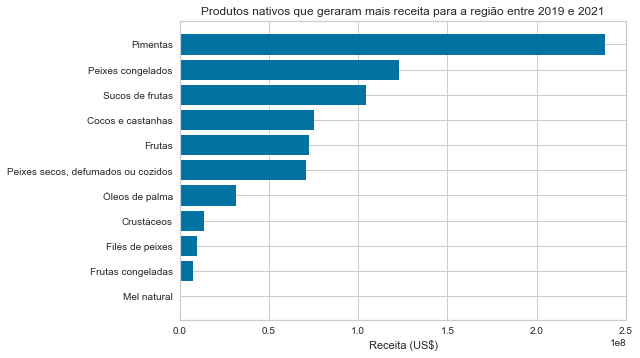

In [176]:
def most_revenue(df):
    
    df = df[['Produtos','Valor']].groupby('Produtos').sum().sort_values(by='Valor',ascending=True).reset_index()
    
    plt.barh(df['Produtos'],df['Valor'])
    plt.xlabel("Receita (US$)")
    plt.title("Produtos nativos que geraram mais receita para a região entre 2019 e 2021")

In [ ]:
most_revenue(df)

É possível perceber algumas diferenças em relação a esse gráfico e a tabela apresentada no estudo de referência. Isso ocorre pois, para este trabalho, os produtos estão sendo classificados pelo código SH4, que fornece uma descrição mais ampla do que o código SH6. Por conta disso, o óleo de Dendê, que é o terceiro produto mais comercializado da região não aparece no gráfico acima, dado que está contido dentro da categoria Óleos de palma.

## 3) Preparação dos dados

### 3.1) Visualização da distribuição dos dados

A seguir, são mostrados o histograma dos dados de valor exportado, a fim de inferir a normalidade da distribuição através do Skewness e da Kurtosis e o boxplot para identificar os outliers.

In [274]:
df1 = df.drop(columns='Codigo_SH4')

In [275]:
def hist_n(df,feature):
    
    df = df[feature]
    
    print('Skewness: ',df.skew())
    print('Kurtosis: ',df.kurt()) 
    
    plt.hist(df)
    plt.title("Histograma dos dados")
    plt.xlabel(feature)
    plt.ylabel('Frequência')
    plt.show()

Skewness:  8.912700244091264
Kurtosis:  95.18498608315458


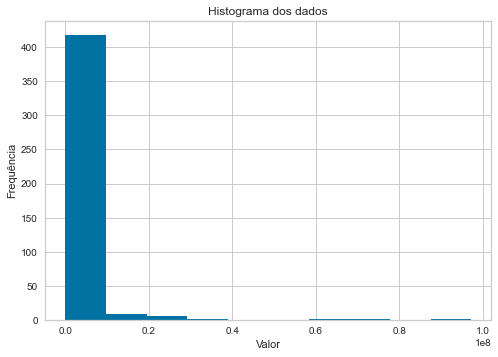

In [276]:
hist_n(df1,'Valor')

In [277]:
def box_plot_out(df,feature):
    
    df = df[feature]
    
    plt.boxplot(df,vert=False)
    plt.title("Boxplot dos dados")
    plt.xlabel(feature)
    plt.show()

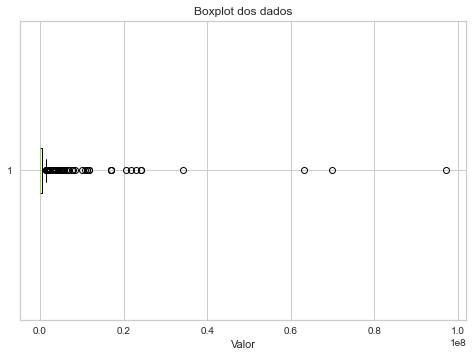

In [278]:
box_plot_out(df1,'Valor')

É possível perceber que a distribuição dos dados não é normal, dado que há uma grande concentração de dados à esquerda para valores próximos de zero. Além disso, há muitos outliers à direita, caracterizados por registros de municípios que possuem valores de vendas muito altos.

### 3.2) Transformação dos dados

Para resolver esse problema, foi realizada uma transformação Box Cox nos dados. A seguir, pode ser visto que de fato os dados assumiram uma distribuição normalizada e que esse novo formato não apresentou novos outliers.

In [279]:
def box_cox_t(df1,feature): 
    
    df1[feature],lambda1 = stats.boxcox(df1[feature])
    
    return df1

Skewness:  -0.012803116443566027
Kurtosis:  -0.7989145972111995


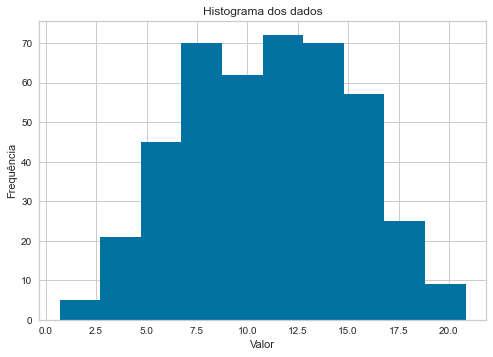

In [280]:
df1= box_cox_t(df1,'Valor')
hist_n(df1,'Valor')

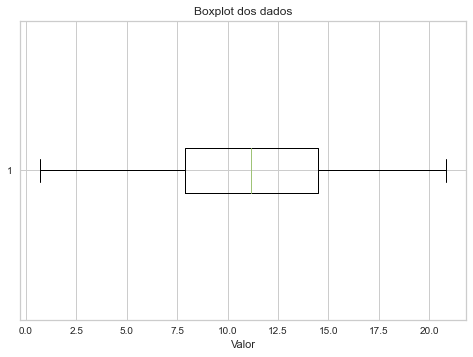

In [281]:
box_plot_out(df1,'Valor')

### 3.3) Padronização dos dados

Por fim, os dados númericos serão padronizados pelo método do Z-Score para que possam ser posteriormente inseridos no modelo de clustering.

In [282]:
def z_score_t(df1):
    
    df1.Latitude = (df1.Latitude -df1.Latitude.mean())/df1.Latitude.std()
    df1.Longitude = (df1.Longitude -df1.Longitude.mean())/df1.Longitude.std()
    df1.Valor = (df1.Valor -df1.Valor.mean())/df1.Valor.std()  
    
    return df1

In [283]:
df1 = z_score_t(df1)
df1.head()

,Ano,Produtos,Estado,Municipio,Valor,Latitude,Longitude
0,2021,Pimentas,Pará,Castanhal,2.353927,-0.200573,-0.111943
1,2021,Sucos de frutas,Pará,Castanhal,1.926760,-0.200573,-0.111943
2,2021,Frutas congeladas,Pará,Castanhal,1.141470,-0.200573,-0.111943
3,2021,Frutas,Pará,Castanhal,0.839312,-0.200573,-0.111943
4,2020,Pimentas,Pará,Castanhal,2.221394,-0.200573,-0.111943


In [284]:
df1.shape

(436, 7)

## 4) Modelagem

### 4.1) Obtenção do número ótimo de clusters para cada produto

A primeira etapa da fase de modelagem envolve determinar o melhor valor de k para realizar a clusterização de cada família de produtos. A seguir foram definidas duas funções para auxiliar esse processo. A primeira utiliza o Elbow Method para determinar o melhor valor de k recebendo como entrada os registros de cada família de produtos selecionados e a segunda utiliza o Silhouette Visualizer.

In [293]:
def elbow_method(data,feature):
    
    import warnings
    
    warnings.filterwarnings("ignore")
    
    x = data.loc[data.Produtos == feature][['Valor','Latitude','Longitude']]
       
    kmeans = KMeans()
    
    print('Produto: ',feature)

    KElbow = KElbowVisualizer(kmeans, k=(1,x.shape[0]-1)).fit(x)

    KElbow.show()

#### 4.1.1) Pimentas 

Produto:  Pimentas


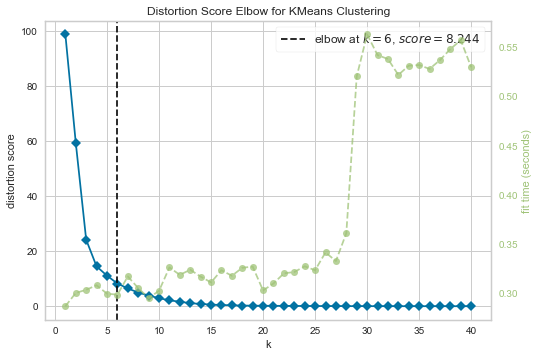

In [294]:
elbow_method(df1,'Pimentas')

Para a família das Pimentas, tem-se pelo Elbow Method que **k = 6**.

#### 4.1.2) Sucos de frutas 

Produto:  Sucos de frutas


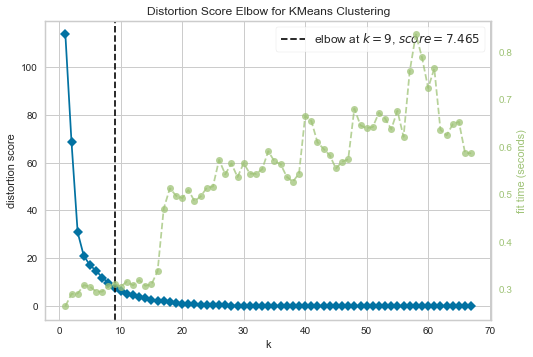

In [304]:
elbow_method(df1,'Sucos de frutas')

Para a família das Sucos de frutas, tem-se pelo Elbow Method que **k = 9**.

#### 4.1.3) Frutas congeladas 

Produto:  Frutas congeladas


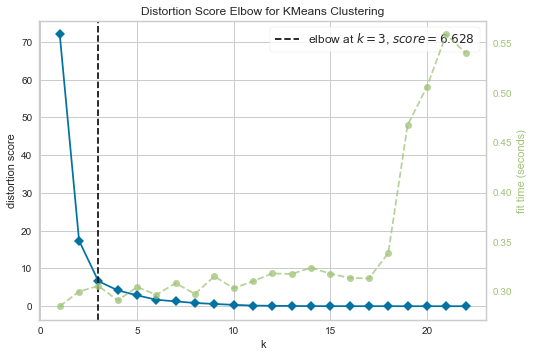

In [305]:
elbow_method(df1,'Frutas congeladas')

Para a família das Frutas congeladas, tem-se pelo Elbow Method que **k = 3**.

#### 4.1.4) Frutas 

Produto:  Frutas


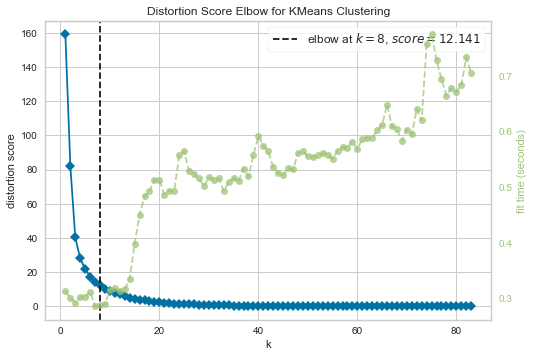

In [306]:
elbow_method(df1,'Frutas')

Para a família das Frutas congeladas, tem-se pelo Elbow Method que **k = 8**.

#### 4.1.5) Óleos de palma 

Produto:  Óleos de palma


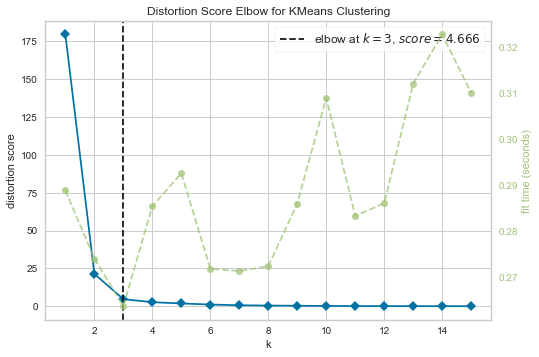

In [315]:
elbow_method(df1,'Óleos de palma')

Para a família dos Óleos de palma, tem-se pelo Elbow Method que **k = 3**.

#### 4.1.6) Cocos e castanhas 

Produto:  Cocos e castanhas


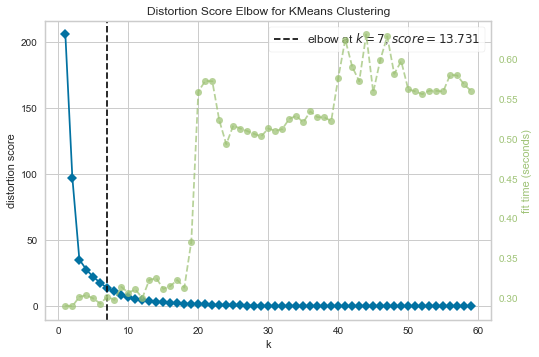

In [308]:
elbow_method(df1,'Cocos e castanhas')

Para a família das Cocos e castanhas, tem-se pelo Elbow Method que **k = 7**.

#### 4.1.7) Peixes congelados 

Produto:  Peixes congelados


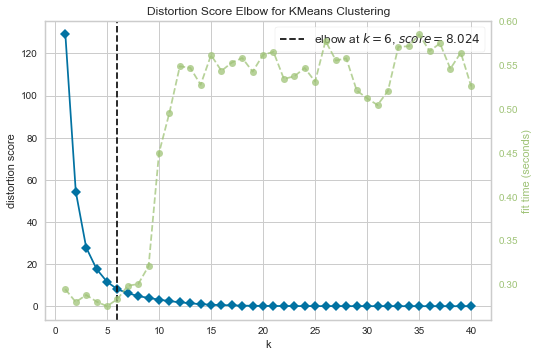

In [310]:
elbow_method(df1,'Peixes congelados')

Para a família das Peixes congelados, tem-se pelo Elbow Method que **k = 6**.

#### 4.1.8) Peixes secos, defumados ou cozidos 

Produto:  Peixes secos, defumados ou cozidos


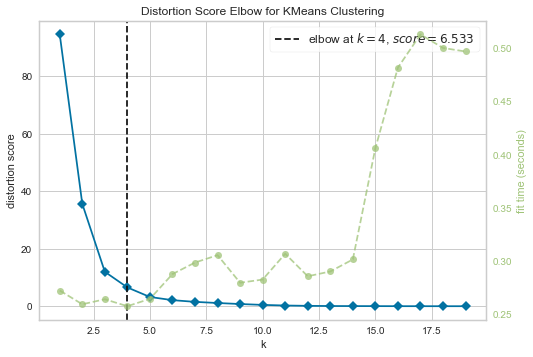

In [311]:
elbow_method(df1,'Peixes secos, defumados ou cozidos')

Para a família das Peixes secos, defumados ou cozidos, tem-se pelo Elbow Method que **k = 4**.

#### 4.1.9) Crustáceos 

Produto:  Crustáceos


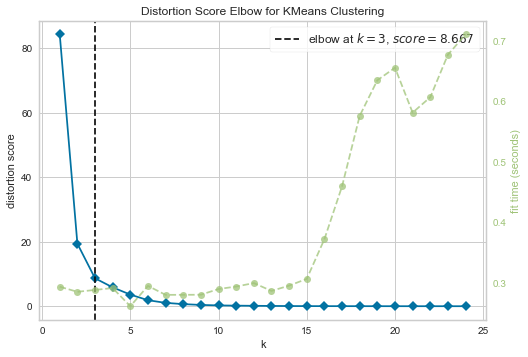

In [312]:
elbow_method(df1,'Crustáceos')

Para a família dos Crustáceos, tem-se pelo Elbow Method que **k = 3**.

#### 4.1.10) Filés de peixes

Produto:  Filés de peixes


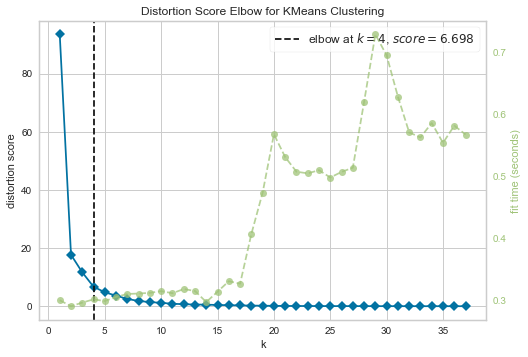

In [313]:
elbow_method(df1,'Filés de peixes')

Para a família dos Filés de peixes, tem-se pelo Elbow Method que **k = 4**.

#### 4.1.11) Mel natural 

Produto:  Mel natural


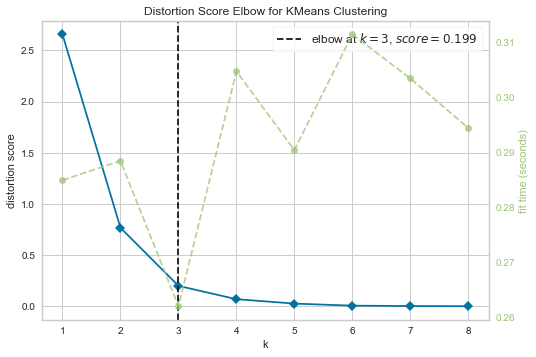

In [314]:
elbow_method(df1,'Mel natural')

Para a família do Mel natural, tem-se pelo Elbow Method que **k = 3**.

### 4.2) Construção do modelo

A segunda função cria um DataFrame de espaço nulo e, para cada família de produtos, calcula os clusters dos registros utilizando os valores de k previamente definidos. Ao final, o registros são novamente salvos no DataFrame com a adição de uma nova coluna indicando seu cluster e o grupo ao qual ele pertence (ex: Pimentas - 0).

In [316]:
def groups(df,df1): 
    
    df3 = pd.DataFrame()  
    
    prod_k = [
        ['Pimentas',6],
        ['Sucos de frutas',9],
        ['Frutas congeladas',3],
        ['Frutas',8],
        ['Óleos de palma',3],
        ['Cocos e castanhas',7],
        ['Peixes congelados',6],
        ['Peixes secos, defumados ou cozidos',4],
        ['Crustáceos',3],
        ['Filés de peixes',4],
        ['Mel natural',3]
    ]
    
    for i in prod_k:
        
        df4 = df1.loc[df1.Produtos == i[0]].reset_index().drop(columns='index')
        df4 = df4[['Valor','Latitude','Longitude']] 
        
        kmeans = KMeans(n_clusters=i[1])  
        
        clusters = kmeans.fit_predict(df4)  
        
        df5 = df.loc[df.Produtos == i[0]].reset_index().drop(columns='index')
        df5['Cluster'] = clusters    
        
        df3 = pd.concat([df3, df5], ignore_index=True)
        
    df3['Nome_grupo'] = df3['Produtos'] + ' - ' + df3['Cluster'].astype('str') 
    
    return df3

In [318]:
groups(df,df1).head()

,Ano,Codigo_SH4,Produtos,Estado,Municipio,Valor,Latitude,Longitude,Cluster,Nome_grupo
0,2021,904,Pimentas,Pará,Castanhal,97191878,-1.292703,-47.922390,4,Pimentas - 4
1,2020,904,Pimentas,Pará,Castanhal,63208109,-1.292703,-47.922390,4,Pimentas - 4
2,2019,904,Pimentas,Pará,Castanhal,69957263,-1.292703,-47.922390,4,Pimentas - 4
3,2021,904,Pimentas,Pará,Belém,1264,-1.450560,-48.468245,0,Pimentas - 0
4,2020,904,Pimentas,Pará,Belém,1303,-1.450560,-48.468245,0,Pimentas - 0


A terceira função utiliza o dataframe criado anteriormente e faz uma agregação para descobrir quais são os cinco grupos que mais geraram valor de exportação no período. 

In [379]:
def top_groups(df3):    
    
    df6 = df3.groupby('Nome_grupo')[['Nome_grupo','Valor']].sum().reset_index().sort_values(by='Valor',ascending=False)
    df6['Valor_%'] = (df6['Valor']/df6['Valor'].sum())*100
    df6['Valor_%_cum'] = (df6['Valor_%'].cumsum())
    df6 = df6.head(6)
    
    return df6

In [380]:
print('Valor total exportado (US$): ',top_groups(groups(df,df1)).Valor.sum())
top_groups(groups(df,df1))

Valor total exportado (US$):  558333728


,Nome_grupo,Valor,Valor_%,Valor_%_cum
42,Pimentas - 4,230357250,30.884362,30.884362
32,Peixes congelados - 4,85407001,11.450652,42.335014
35,"Peixes secos, defumados ou cozidos - 1",69325011,9.294514,51.629528
48,Sucos de frutas - 4,68384599,9.168432,60.797960
18,Frutas - 4,59138320,7.928768,68.726728
1,Cocos e castanhas - 1,51783753,6.942730,75.669458


Apesar da saída ser um resultado satisfatório, ele pode não ser o melhor, dado que o algorítmo K-Means possui um fator de aleatoriedade na sua inicialização que impacta no resultado final. Logo, para descobrir uma melhor configuração possível, o modelo precisa ser rodado várias vezes.

A função a seguir executa o modelo 100 vezes e retorna o maior o valor total exportado pelos seis grupos com maior valor de exportação.

In [345]:
def max_value(df,df1):    
    
    l = []   
    
    for i in range(100): 
        
        df7 = groups(df,df1)   
        
        l.append(top_groups(df7).Valor.sum())  
        
        m = max(l)   
        
    return m

In [381]:
m = max_value(df,df1)
m

590874645

Por fim, uma nova função calcula novos grupos até que o valor total exportado pela configuração dos cinco melhores alcance o maior valor total exportado calculado por meio da função anterior. Com isso, é possível obter a melhor configuração possível. 

In [359]:
def best_configuration(df,df1,m):     
    
    df8 = groups(df,df1)     
    df9 = top_groups(df8) 
    
    while df9.Valor.sum() < m:  
        
        df8 = groups(df,df1)        
        df9 = top_groups(df8)   
        
    else:       
        
        return df8

In [382]:
df10 = best_configuration(df,df1,m)

## 5) Avaliação

### 5.1) Grupos com maiores valores de exportação acumulados entre 2019 e 2021

A análise dos resultados envolve entender quais grupos são os que mais geram receita para a região, pois, ao focar na criação de arranjos pré-competitivos nestes, é possível gerar mais valor economico com um menor esforço. Para isso, os grupos foram ordenados em ordem decrescente de valor exportado e foram selecionados os cinco maiores.

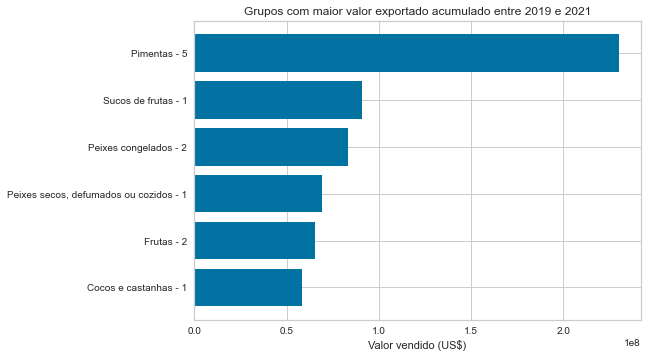

Valor total comercializado pelos grupos no período: US$ 597648502
Participação dos grupos em relação ao valor total exportado no período:  80.13 %


In [383]:
def best_configuration_viz(df11):
    
    df11 = top_groups(df11).sort_values(by='Valor',ascending=True).tail(6)
    df11['Valor_%'] = df11['Valor']/df11['Valor'].sum()
    
    plt.barh(df11['Nome_grupo'],df11['Valor_%'])
    plt.title('Grupos com maior valor exportado acumulado entre 2019 e 2021')
    plt.xlabel('Valor vendido (US$)')
    plt.show()
    
    print('Valor total comercializado pelos grupos no período: US$',df11['Valor_%'].sum())
    print('Participação dos grupos em relação ao valor total exportado no período: ',round((df11['Valor'].sum()*100/df.Valor.sum()),2).astype('str'),'%')
    
best_configuration_viz(df10)

Como pode ser visto, os sete grupos mostrados são responsáveis por 80% do faturamento da região. 

### 5.2) Análise dos grupos

A função a seguir, fornece análises mais detalhadas para entender quais municípios pertencem a cada um desses grupos assim como suas distribuições no território.

In [384]:
def analise_grupo(df10,name):
    
    df10 = df10.loc[df10.Nome_grupo == name]
    df10 = df10[["Produtos","Cluster","Municipio","Estado","Latitude","Longitude","Valor"]].groupby(["Produtos","Cluster","Municipio","Estado","Latitude","Longitude"]).sum().reset_index().sort_values(by='Valor',ascending=False)
    
    print('Valor médio de exportação anual: US$',df10.Valor.sum())
    
    return df10

#### 5.2.1) Pimentas - 5

O primeiro grupo identificado é o grupo Pimentas - 5. Ele é formado apenas pelo município de Castanhal-PA e é o que mais contribui com a economia de exportação da região.

In [386]:
analise_grupo(df10,'Pimentas - 5')

Valor médio de exportação anual: US$ 230357250


,Produtos,Cluster,Municipio,Estado,Latitude,Longitude,Valor
0,Pimentas,5,Castanhal,Pará,-1.292703,-47.92239,230357250


#### 5.2.2) Sucos de frutas - 1

O segundo grupo identificado é o grupo Sucos de frutas - 1. Ele é formado pelos municípios de Castanhal-PA, Santana-AP, Floresta do Araguaia-PA, Barcarena-PA, Capitão Poço-PA e Abaetetuba-PA.

In [387]:
analise_grupo(df10,'Sucos de frutas - 1')

Valor médio de exportação anual: US$ 90884000


,Produtos,Cluster,Municipio,Estado,Latitude,Longitude,Valor
3,Sucos de frutas,1,Castanhal,Pará,-1.292703,-47.922390,62910650
5,Sucos de frutas,1,Santana,Amapá,-12.979217,-44.050640,10646418
4,Sucos de frutas,1,Floresta do Araguaia,Pará,-7.559706,-49.703283,7013492
1,Sucos de frutas,1,Barcarena,Pará,-1.510795,-48.619068,5473949
2,Sucos de frutas,1,Capitão Poço,Pará,-1.744716,-47.063850,2421661
0,Sucos de frutas,1,Abaetetuba,Pará,-1.721828,-48.878843,2417830


####  5.2.3) Peixes congelados - 2

O terceiro grupo identificado é o grupo Peixes congelados - 2. Ele é formado pelos municípios de Belém-PA, Augusto Corrêa-PA e Curuçá-PA.

In [388]:
analise_grupo(df10,'Peixes congelados - 2')

Valor médio de exportação anual: US$ 83160586


,Produtos,Cluster,Municipio,Estado,Latitude,Longitude,Valor
1,Peixes congelados,2,Belém,Pará,-1.450560,-48.468245,74222349
0,Peixes congelados,2,Augusto Corrêa,Pará,-1.022933,-46.640403,6677637
2,Peixes congelados,2,Curuçá,Pará,-0.727679,-47.856568,2260600


#### 5.2.4) Peixes secos, defumados ou cozidos - 1

O quarto grupo identificado é o grupo Peixes secos, defumados ou cozidos - 1. Ele é formado pelos municípios de Belém-PA, Ananindeua-PA e Vigia-PA.

In [389]:
analise_grupo(df10,'Peixes secos, defumados ou cozidos - 1')

Valor médio de exportação anual: US$ 69325011


,Produtos,Cluster,Municipio,Estado,Latitude,Longitude,Valor
1,"Peixes secos, defumados ou cozidos",1,Belém,Pará,-1.450560,-48.468245,61614170
0,"Peixes secos, defumados ou cozidos",1,Ananindeua,Pará,-1.374035,-48.401662,7640800
2,"Peixes secos, defumados ou cozidos",1,Vigia,Pará,-0.854603,-48.143287,70041


#### 5.2.5) Frutas - 2

O quinto grupo identificado é o grupo Frutas - 2. Ele é formado pelos municípios de Santarena-AP, Bacarena-PA, Inhagapi-PA, Abaetetuba-PA e Santa Bárbara do Pará-PA.

In [390]:
analise_grupo(df10,'Frutas - 2')

Valor médio de exportação anual: US$ 65364045


,Produtos,Cluster,Municipio,Estado,Latitude,Longitude,Valor
4,Frutas,2,Santana,Amapá,-12.979217,-44.050640,26712527
1,Frutas,2,Barcarena,Pará,-1.510795,-48.619068,18700227
2,Frutas,2,Inhangapi,Pará,-1.428374,-47.910861,10806488
0,Frutas,2,Abaetetuba,Pará,-1.721828,-48.878843,5787541
3,Frutas,2,Santa Bárbara do Pará,Pará,-1.226144,-48.295101,3357262


#### 5.2.6) Cocos e castanhas - 1

O sexto grupo identificado é o grupo Cocos e castanhas - 1. Ele é formado pelos municípios de Oriximiná-PA, Manaus-AM, Rio Branco-AC, Belém-PA e Brasiléia-AC.

In [391]:
analise_grupo(df10,'Cocos e castanhas - 1')

Valor médio de exportação anual: US$ 58557610


,Produtos,Cluster,Municipio,Estado,Latitude,Longitude,Valor
3,Cocos e castanhas,1,Oriximiná,Pará,-1.766999,-55.868285,16433120
2,Cocos e castanhas,1,Manaus,Amazonas,-3.131633,-59.982504,13565614
4,Cocos e castanhas,1,Rio Branco,Acre,-9.976536,-67.822078,9867872
0,Cocos e castanhas,1,Belém,Pará,-1.450560,-48.468245,9497088
1,Cocos e castanhas,1,Brasiléia,Acre,-11.001041,-68.748789,9193916
